In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# DATA EXPLORATION AND PREPROCESSING

In [2]:
#Loading the Dataset
zomato = pd.read_csv("C:/Users/Kemal/Desktop/zomato.csv")

In [3]:
#The Dataset's shape
zomato.shape

(51717, 17)

In [4]:
#Columns of the Dataset
zomato.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

   ###   Descriptions of column labels;
   - url: contains the url of the restaurant in the zomato website
   - address: contains the address of the restaurant in Bengaluru
   - name: contains the name of the restaurant
   - online_order: whether online ordering is available in the restaurant or not
   - book_table: table book option available or not
   - rate: contains the overall rating of the restaurant out of 5
   - votes: contains total number of rating for the restaurant
   - phone: contains the phone number of the restaurant
   - location: contains the neighborhood in which the restaurant is located
   - rest_type: type of the restaurant
   - dish_liked: dishes people liked in the restaurant
   - cuisines: food styles, separated by comma
   - approx_cost(for two people): contains approximate meal cost for two people
   - reviews_list: list of tuples containing reviews for the restaurant
   - menu_item: contains list of menus available in the restaurant
   - listed_in(type): type of meal
   - listed_in(city): contains city in which the restaurant is located





In [5]:
#Changing some columns' names
zomato = zomato.rename(columns={"approx_cost(for two people)":"approx_cost","listed_in(type)":"meals","listed_in(city)":"city"})

In [6]:
#Cleaning redundant columns; "url","address" and "phone" - keeping "location" column for address information
zomato = zomato.drop(['url','address','phone'], axis=1)
#"location" and "city" columns contain same information but "location" has wider range so drop the "city" column
zomato = zomato.drop(['city'], axis=1) 

In [7]:
#Datatypes of attributes
zomato.dtypes

name            object
online_order    object
book_table      object
rate            object
votes            int64
location        object
rest_type       object
dish_liked      object
cuisines        object
approx_cost     object
reviews_list    object
menu_item       object
meals           object
dtype: object

In [8]:
#Changing datatype of "approx_cost" column from object to float
zomato['approx_cost'] = zomato['approx_cost'].astype(str).apply(lambda x: x.replace(',',''))
zomato['approx_cost'] = zomato['approx_cost'].astype(float)

In [9]:
#For "rate" column: drop "/5" part - change datatype from object to float - fix noisy entries
zomato['rate'] = zomato['rate'].astype(str).apply(lambda x: x.split('/')[0])
while True:
    try:
        zomato['rate'] = zomato['rate'].astype(float)
        break
    except ValueError as e1:
        noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
        zomato['rate'] = zomato['rate'].apply(lambda x: x.replace(noise_entry, str(np.nan)))

In [10]:
# Correcting the noisy restaurant name entries
zomato['name'] = zomato['name'].apply(lambda x: 'Santa Spa Cuisine' if x == 'SantÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â© Spa Cuisine' else x)

zomato['name'] = zomato['name'].apply(lambda x: 'Cafe Down The Alley' if x == 'CafÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â© Down The Alley' else x)

zomato['name'] = zomato['name'].apply(lambda x: 'Cafe Shangri-La Hotel' if x == 'b CafÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â© - Shangri-La Hotel' else x)

In [11]:
#Missing value search
number_of_missing_data = (zomato.isnull().sum()).sort_values(ascending=False)
number_of_missing_data = pd.DataFrame(number_of_missing_data, columns=['# of missing values'])                                                                    
percentage_of_missing_data = (zomato.isnull().sum()/zomato.shape[0]*100).sort_values(ascending=False)
percentage_of_missing_data = pd.DataFrame(percentage_of_missing_data, columns=['% of missing part'])
missing = pd.concat([number_of_missing_data,percentage_of_missing_data], axis=1) 

missing
       

,# of missing values,% of missing part
dish_liked,28078,54.291626
rate,10052,19.436549
approx_cost,346,0.669026
rest_type,227,0.438927
cuisines,45,0.087012
location,21,0.040606
meals,0,0.000000
menu_item,0,0.000000
reviews_list,0,0.000000
votes,0,0.000000


In [12]:
zomato = zomato.drop(['dish_liked'], axis=1) #dish_liked attribute has too many missing value so drop it

In [13]:
#Remove missing value containing rows - Remaining part = 41.263 rows
zomato = zomato.dropna(how='any')
zomato = zomato.reset_index(drop=True)

In [14]:
#Search for duplicated rows
zomato.duplicated().value_counts()

False    34322
True      6941
dtype: int64

In [15]:
#Remove duplicated rows - Remaining part = 34.322 rows
zomato = zomato.drop_duplicates()

In [16]:
#Removo rows whose number of votes is smaller than 50, because rate data of restaurants change by 0.1 interval
#Adding 1 more vote to a restaurant whose vote number is smaller than 50 may cause more than 0.1 difference on average rate
#Having more than 50 votes guarantees that the restaurants average rate will not change more than 0.1 by adding 1 more vote
#It means that restaurant's rate is settled and reliable 
#Remaining part = 21.719 rows
zomato = zomato[zomato.votes > 49]
zomato = zomato.reset_index(drop=True)

## DATA VISUALIZATION AND FEATURE SELECTION

### Top 5 restaurants for different features  

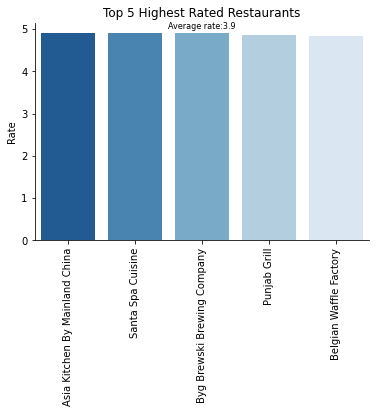

In [17]:
rest_names = (zomato.groupby(by='name', as_index=False).agg({'votes': 'sum','approx_cost': 'mean','rate': 'mean'})).sort_values(["votes"], ascending=False)

fig, ax=plt.subplots()
sns.barplot(x='name' , y='rate' , palette='Blues_r' , data=rest_names.sort_values(by='rate' , ascending=False).head(5)).set_title('Top 5 Highest Rated Restaurants', size=12)
avg = zomato.rate.mean()
ax.text(2, 5, 'Average rate:3.9', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

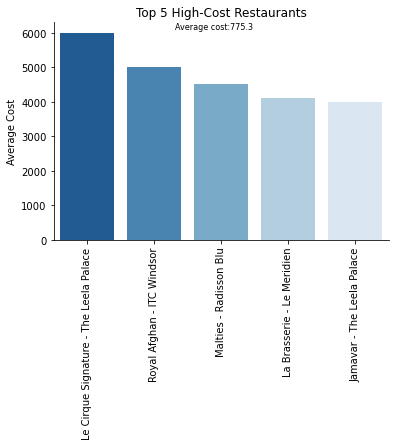

In [18]:
fig, ax2=plt.subplots()
sns.barplot(x='name' , y='approx_cost' , palette='Blues_r' , data=rest_names.sort_values(by='approx_cost' , ascending=False).head(5)).set_title('Top 5 High-Cost Restaurants', size=12)
avg2 = zomato.approx_cost.mean()
ax2.text(1.9, 6100, 'Average cost:775.3', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax2.set_xlabel('')
ax2.set_ylabel('Average Cost')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

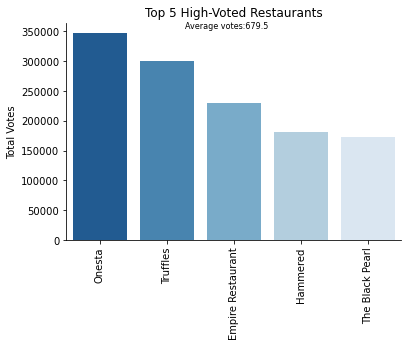

In [19]:
fig, ax3=plt.subplots()
sns.barplot(x='name' , y='votes' , palette='Blues_r' , data=rest_names.sort_values(by='votes' , ascending=False).head(5)).set_title('Top 5 High-Voted Restaurants', size=12)
avg3 = zomato.votes.mean()
ax3.text(1.9, 355000, 'Average votes:679.5', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('Total Votes')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

### Top 20 locations for different features 

In [20]:
rest_locs = (zomato.groupby(by='location', as_index=False).agg({'name':'count','votes': 'sum','approx_cost': 'mean','rate': 'mean'})).sort_values(["votes"], ascending=False)

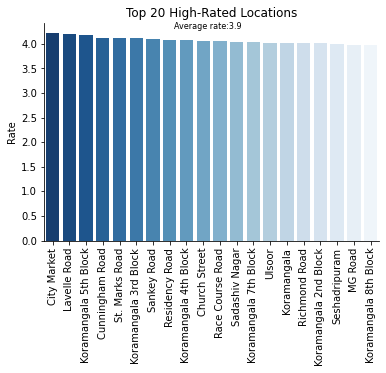

In [21]:
fig, ax=plt.subplots()
sns.barplot(x='location' , y='rate' , palette='Blues_r' , data=rest_locs.sort_values(by='rate' , ascending=False).head(20)).set_title('Top 20 High-Rated Locations', size=12)
avg = zomato.rate.mean()
ax.text(9.3, 4.3, 'Average rate:3.9', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

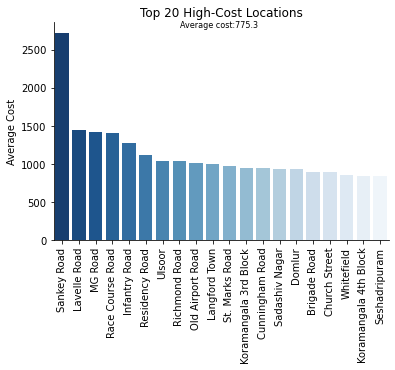

In [22]:
fig, ax2=plt.subplots()
sns.barplot(x='location' , y='approx_cost' , palette='Blues_r' , data=rest_locs.sort_values(by='approx_cost' , ascending=False).head(20)).set_title('Top 20 High-Cost Locations', size=12)
avg2 = zomato.approx_cost.mean()
ax2.text(9.4, 2800, 'Average cost:775.3', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax2.set_xlabel('')
ax2.set_ylabel('Average Cost')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

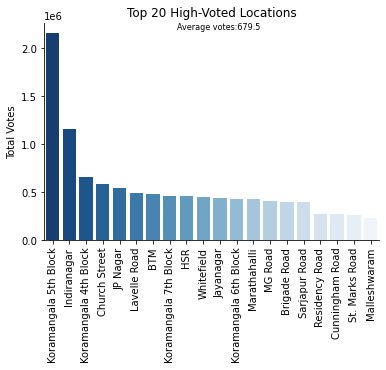

In [23]:
fig, ax3=plt.subplots()
sns.barplot(x='location' , y='votes' , palette='Blues_r' , data=rest_locs.sort_values(by='votes' , ascending=False).head(20)).set_title('Top 20 High-Voted Locations', size=12)
avg3 = zomato.votes.mean()
ax3.text(9.9, 2200000, 'Average votes:679.5', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('Total Votes')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

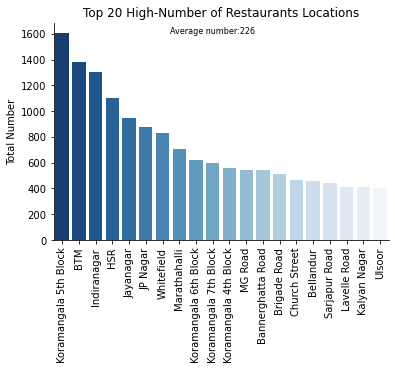

In [24]:
fig, ax4=plt.subplots()
sns.barplot(x='location' , y='name' , palette='Blues_r' , data=rest_locs.sort_values(by='name' , ascending=False).head(20)).set_title('Top 20 High-Number of Restaurants Locations', size=12)
avg4 = rest_locs.name.mean()
ax4.text(9, 1600, 'Average number:226', fontsize=8, ha='center')
plt.xticks(rotation=90)
ax4.set_xlabel('')
ax4.set_ylabel('Total Number')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

### Correlation search between numerical attributes and rate 

Pearson Correlation and p-value between approx cost and rate is: (0.33536373234734884, 0.0)
Pearson Correlation and p-values between votes and rate is: (0.3905445957997734, 0.0)


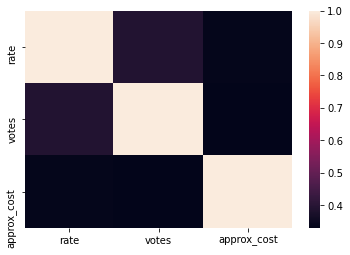

In [25]:
pearson1 = stats.pearsonr(zomato.loc[:,'approx_cost'] , zomato.loc[:,'rate'])
print("Pearson Correlation and p-value between approx cost and rate is:", pearson1)
pearson2 = stats.pearsonr(zomato.loc[:,'votes'] , zomato.loc[:,'rate'])
print("Pearson Correlation and p-values between votes and rate is:", pearson2)

sns.heatmap(zomato.corr()).set_title=('Heatmap graph of correlations')

#Both "approx_cost" and "votes" attributes have correlation with "rate" but "votes" attribute has higher correlation

SpearmanrResult(correlation=0.3931536426725067, pvalue=0.0)
SpearmanrResult(correlation=0.5848033717445892, pvalue=0.0)


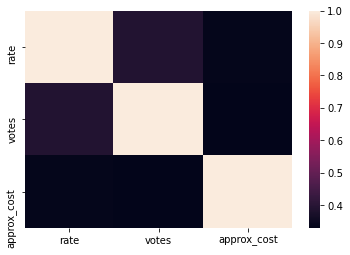

In [26]:
spearman1 = stats.spearmanr(zomato.loc[:,'approx_cost'] , zomato.loc[:,'rate'])
print(spearman1)
spearman2 = stats.spearmanr(zomato.loc[:,'votes'] , zomato.loc[:,'rate'])
print(spearman2)

sns.heatmap(zomato.corr()).set_title=('Heatmap graph of correlations')

#Both "approx_cost" and "votes" attributes have correlation with "rate" but "votes" attribute has higher correlation

### Correlation search between categorical attributes and rate 

In [27]:
zomato_cat = zomato.select_dtypes(include=object)

attributes = []
cor_values = []
p_values = []

for i in range(len(zomato_cat.columns)):
    attributes.append(zomato_cat.columns[i])
    cor_val, p_val = stats.spearmanr(zomato_cat.iloc[:,i], zomato.loc[:,'rate'])
    cor_values.append(cor_val)
    p_values.append(p_val)

df1 = pd.DataFrame(attributes, columns = ["Attributes"])
df2 = pd.DataFrame(cor_values, columns = ["Spearman Corr."])
df3 = pd.DataFrame(p_values, columns = ["P-Values"])

df2 = df2.abs()

df  = pd.concat([df1,df2,df3], axis=1)
df  = df.sort_values(["Spearman Corr."], ascending = False)
df  = df.reset_index(drop=True)

df

#Most correlated attribute is 'book_table' and all attributes have meaningful correlation score so use all of them for modelling

,Attributes,Spearman Corr.,P-Values
0,book_table,0.430038,0.000000e+00
1,reviews_list,0.313205,0.000000e+00
2,rest_type,0.198820,1.730277e-192
3,location,0.142052,2.802629e-98
4,online_order,0.122848,8.538578e-74
5,cuisines,0.107415,9.408429e-57
6,meals,0.060273,6.100152e-19
7,menu_item,0.048109,1.306226e-12
8,name,0.018620,6.066922e-03


<AxesSubplot:xlabel='book_table', ylabel='rate'>

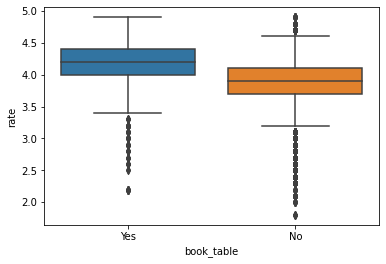

In [28]:
sns.boxplot(y="rate", x="book_table", data= zomato)

# DATA MODELLING AND PREDICTION

### Preperation of dataset for modelling and assigning success score

In [29]:
#Generate a new "success" column and assign each restaurant's score: 1 for success 0 for fail

zomato["success"] = ""

for i in range(zomato.shape[0]):
    for j in range (rest_locs.shape[0]):
        if zomato.loc[i,"location"] == rest_locs.loc[j,"location"]:
            if zomato.loc[i,"rate"] >= rest_locs.loc[j,"rate"]:
                zomato.loc[i,"success"] = 1
            else:
                zomato.loc[i,"success"] = 0
                
#If a restaurant's average rate is greater or equal to the average rate of restaurants at its location; It is counted as successful else failed

In [30]:
zomato['success'] = zomato['success'].astype('int')

### Get dummies of categorical attributes

In [31]:
zomato_x = zomato.loc[0:1000,"name":"meals"]
zomato_x = pd.get_dummies(zomato_x)
zomato_y = zomato.loc[0:1000,"success"]

### Logistic Regression Algorithm 

In [32]:
#Aplly 10 times and take average for more reliable results

lg_reg_accuracy_percentage_tot = 0
time_lg_reg_tot = 0

for m in range (10):

#Splitting train and test datasets   
    zomato_x_train, zomato_x_test, zomato_y_train, zomato_y_test = train_test_split(zomato_x, zomato_y, test_size=0.2)
    zomato_y_test = zomato_y_test.reset_index(drop=True)

    tic_lg_reg = time.time()

#Logistic regression algorithm application
    lg_reg = LogisticRegression(solver='lbfgs', max_iter=100000)
    model_lg_reg = lg_reg.fit(zomato_x_train, zomato_y_train)
    lg_reg_predictions = model_lg_reg.predict(zomato_x_test)

#Logistic regression algorithm's prediction accuracy
    true_lg_reg = 0
    for i in range (len(lg_reg_predictions)):
        if zomato_y_test[i] == lg_reg_predictions[i]:
            true_lg_reg += 1
    lg_reg_accuracy_percentage = (true_lg_reg/len(lg_reg_predictions))*100

    toc_lg_reg = time.time()
    time_lg_reg = toc_lg_reg-tic_lg_reg
   
    lg_reg_accuracy_percentage_tot += lg_reg_accuracy_percentage
    time_lg_reg_tot += time_lg_reg
              
lg_reg_accuracy_percentage = lg_reg_accuracy_percentage_tot/10    
time_lg_reg = time_lg_reg_tot/10

print("Accuracy: %",lg_reg_accuracy_percentage)
print("Time:",time_lg_reg,"s")

Accuracy: % 97.0646766169154
Time: 7.141563296318054 s


### Decision Tree Algorithm

In [33]:
#Aplly 10 times and take average for more reliable results

dec_tree_accuracy_percentage_tot = 0
time_dec_tree_tot = 0

for m in range (10):
    
#Splitting train and test datasets    
    zomato_x_train, zomato_x_test, zomato_y_train, zomato_y_test = train_test_split(zomato_x, zomato_y, test_size=0.2)
    zomato_y_test = zomato_y_test.reset_index(drop=True)

    tic_dec_tree = time.time()

#Decision tree algorithm application
    dec_tree = tree.DecisionTreeClassifier()
    model_dec_tree = dec_tree.fit(zomato_x_train, zomato_y_train)
    dec_tree_predictions = model_dec_tree.predict(zomato_x_test)

#Decision tree algorithm's prediction accuracy
    true_dec_tree = 0
    for i in range (len(dec_tree_predictions)):
        if zomato_y_test[i] == dec_tree_predictions[i]:
            true_dec_tree += 1
    dec_tree_accuracy_percentage = (true_dec_tree/len(dec_tree_predictions))*100

    toc_dec_tree = time.time()
    time_dec_tree = toc_dec_tree-tic_dec_tree
   
    dec_tree_accuracy_percentage_tot += dec_tree_accuracy_percentage
    time_dec_tree_tot += time_dec_tree
       
dec_tree_accuracy_percentage = dec_tree_accuracy_percentage_tot/10    
time_dec_tree = time_dec_tree_tot/10

print("Accuracy: %",dec_tree_accuracy_percentage)
print("Time:",time_dec_tree,"s")

Accuracy: % 99.00497512437809
Time: 0.1410158395767212 s


### Random Forest Algorithm

In [34]:
#Aplly 10 times and take average for more reliable results

rand_forest_accuracy_percentage_tot = 0
time_rand_forest_tot = 0

for m in range (10):
    
#Splitting train and test datasets     
    zomato_x_train, zomato_x_test, zomato_y_train, zomato_y_test = train_test_split(zomato_x, zomato_y, test_size=0.2)
    zomato_y_test = zomato_y_test.reset_index(drop=True)

    tic_rand_forest = time.time()

#Random forest algorithm application
    rand_forest = RandomForestClassifier()
    model_rand_forest = rand_forest.fit(zomato_x_train, zomato_y_train)
    rand_forest_predictions = model_rand_forest.predict(zomato_x_test)

#Random forest algorithm's prediction accuracy
    true_rand_forest = 0
    for i in range (len(rand_forest_predictions)):
        if zomato_y_test[i] == rand_forest_predictions[i]:
            true_rand_forest += 1
    rand_forest_accuracy_percentage = (true_rand_forest/len(rand_forest_predictions))*100

    toc_rand_forest = time.time()
    time_rand_forest = toc_rand_forest-tic_rand_forest
   
    rand_forest_accuracy_percentage_tot += rand_forest_accuracy_percentage
    time_rand_forest_tot += time_rand_forest
     
rand_forest_accuracy_percentage = rand_forest_accuracy_percentage_tot/10    
time_rand_forest = time_rand_forest_tot/10

print("Accuracy: %",rand_forest_accuracy_percentage)
print("Time:",time_rand_forest,"s")

Accuracy: % 96.01990049751244
Time: 1.1449961423873902 s


### K-Nearest Neighbours Algorithm

In [35]:
#Aplly 10 times and take average for more reliable results

knn_accuracy_percentage_tot = 0
time_knn_tot = 0

for m in range (10):
    
#Splitting train and test datasets    
    zomato_x_train, zomato_x_test, zomato_y_train, zomato_y_test = train_test_split(zomato_x, zomato_y, test_size=0.2)
    zomato_y_test = zomato_y_test.reset_index(drop=True)

    tic_knn = time.time()

#KNN algorithm application
    knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
    model_knn = knn.fit(zomato_x_train, zomato_y_train)
    knn_predictions = model_knn.predict(zomato_x_test)

#KNN algorithm's prediction accuracy
    true_knn = 0
    for i in range (len(knn_predictions)):
        if zomato_y_test[i] == knn_predictions[i]:
            true_knn += 1
    knn_accuracy_percentage = (true_knn/len(knn_predictions))*100

    toc_knn = time.time()
    time_knn = toc_knn-tic_knn
   
    knn_accuracy_percentage_tot += knn_accuracy_percentage
    time_knn_tot += time_knn
       
knn_accuracy_percentage = knn_accuracy_percentage_tot/10    
time_knn = time_knn_tot/10

print("Accuracy: %",knn_accuracy_percentage)
print("Time:",time_knn,"s")

Accuracy: % 70.44776119402985
Time: 0.701855206489563 s


### Comparison of algorithms' results

In [36]:
algorithms = pd.DataFrame(["Logistic Regression","Decision Tree","Random Forest","KNN"], columns =["Algorithm"])
algorithm_scores = pd.DataFrame([lg_reg_accuracy_percentage,dec_tree_accuracy_percentage,rand_forest_accuracy_percentage,knn_accuracy_percentage], columns=["Accuracy,%"])
algorithm_times = pd.DataFrame([time_lg_reg,time_dec_tree,time_rand_forest,time_knn], columns=["Spend time,s"])
comparison = pd.concat([algorithms,algorithm_scores,algorithm_times], axis=1)
comparison  = comparison.sort_values(["Accuracy,%"], ascending = False)
comparison  = comparison.reset_index(drop=True)

comparison

,Algorithm,"Accuracy,%","Spend time,s"
0,Decision Tree,99.004975,0.141016
1,Logistic Regression,97.064677,7.141563
2,Random Forest,96.019900,1.144996
3,KNN,70.447761,0.701855
